# Spot Nuclei. Speed Cures.
Imagine speeding up research for almost every disease, from lung cancer and heart disease to rare disorders. The 2018 Data Science Bowl offers our most ambitious mission yet: create an algorithm to automate nucleus detection.

We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away. Think how many lives would be transformed if cures came faster.

By automating nucleus detection, you could help unlock cures faster—from rare disorders to the common cold. Want a snapshot about the 2018 Data Science Bowl? View this video.

# Why nuclei?
Identifying the cells’ nuclei is the starting point for most analyses because most of the human body’s 30 trillion cells contain a nucleus full of DNA, the genetic code that programs each cell. Identifying nuclei allows researchers to identify each individual cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work.

By participating, teams will work to automate the process of identifying nuclei, which will allow for more efficient drug testing, shortening the 10 years it takes for each new drug to come to market. Check out this video overview to find out more.



In [1]:
from fastai.vision import *
from fastai.metrics import error_rate

# Import Libraries here
import os
import json 
import shutil
import zipfile
import numpy as np
import pandas as pd
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as TF

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# notebook project directories
base_dir = '/hdd/data/nuclei/'

!mkdir -p "{base_dir}"

# set the random seed
np.random.seed(2)

In [ ]:
# Download the histopathological data
!pip install kaggle
!kaggle competitions download -c data-science-bowl-2018 -p "{base_dir}"

# Check the download here
path = Path(base_dir)
path.ls()

In [53]:
#now unzip the test files
for zipFilePath in path.ls():
    csvIdx = (len(str(zipFilePath)))-8
    csvExtension = str(zipFilePath)[csvIdx:]
    zipIdx = (len(str(zipFilePath)))-4
    zipExtension = str(zipFilePath)[zipIdx:]
    if csvExtension == '.csv.zip' :
        dest_dir_csv = Path(base_dir)
        labels_csv_zip = zipfile.ZipFile(zipFilePath, 'r')
        labels_csv_zip.extractall(dest_dir_csv)
        labels_csv_zip.close()
    elif zipExtension == '.zip':
        zipDestDir = str(zipFilePath)[:zipIdx]
        !mkdir -p "{zipDestDir}/"
        dest_dir_images = Path(zipDestDir + '/')
        images_zip = zipfile.ZipFile(zipFilePath, 'r')
        images_zip.extractall(dest_dir_images)
        images_zip.close()
        
#now check paths to see if they unzipped correctly
path.ls()


[PosixPath('/hdd/data/nuclei/stage2_sample_submission_final.csv'),
 PosixPath('/hdd/data/nuclei/stage2_sample_submission_final.csv.zip'),
 PosixPath('/hdd/data/nuclei/stage1_solution.csv.zip'),
 PosixPath('/hdd/data/nuclei/stage1_sample_submission.csv'),
 PosixPath('/hdd/data/nuclei/stage2_test_final'),
 PosixPath('/hdd/data/nuclei/stage1_solution.csv'),
 PosixPath('/hdd/data/nuclei/stage1_sample_submission.csv.zip'),
 PosixPath('/hdd/data/nuclei/stage1_train'),
 PosixPath('/hdd/data/nuclei/stage1_train_labels.csv'),
 PosixPath('/hdd/data/nuclei/stage1_train_labels.csv.zip'),
 PosixPath('/hdd/data/nuclei/stage2_test_final.zip'),
 PosixPath('/hdd/data/nuclei/stage1_test'),
 PosixPath('/hdd/data/nuclei/stage1_test.zip'),
 PosixPath('/hdd/data/nuclei/stage1_train.zip')]

# Data Block API

Referencing: https://github.com/schwobr/Shared-notebooks/blob/master/dsbowl_fastai_clean.ipynb


In [22]:
"""
    Here are the key folders and CSVs in the data set:

    PosixPath('/hdd/data/nuclei/stage2_test_final'),
    PosixPath('/hdd/data/nuclei/stage1_train'),
    PosixPath('/hdd/data/nuclei/stage1_test'),
    PosixPath('/hdd/data/nuclei/stage1_solution.csv'),
    PosixPath('/hdd/data/nuclei/stage1_train_labels.csv'),
    PosixPath('/hdd/data/nuclei/stage2_sample_submission_final.csv'),
    PosixPath('/hdd/data/nuclei/stage1_sample_submission.csv'),

    In the train folder we have the following structure
    
    stage1_train/
        f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a/
            -> images/
                -> *.png
            -> masks/
                -> *.png
"""

# train and test directories
path_img_train = base_dir + 'stage1_train/' # need to split this folder into train and val sets
path_img_test = base_dir + 'stage1_test/' # images only, use to test

# When we grab images from_folder, we also grab all of the masks
# we want to filter out all of the mask images
def filter_only_training_images(file_path):
    if Path(file_path).match('*/masks/*'):
        return False #if this is an image in the mask directory, return false as it's not a training image
    else:
        return True
    
#lets just grab the masks/labels
def filter_masks_dir(x):
    sample_instance_subfolder = x.parents[1] # go up two levels
    return sample_instance_subfolder / 'masks/'
    
# since the masks for each input are in seperate files, 
# we need to create a custom SegmentLabel class
# to combine these masks together when they are opened
# note that when we pass this to the data block api, we'll pass it in the following fashion:
#    label_from_func(lambda x: x.parents[1] / 'masks/', label_cls=MultiMasksList, classes=['nucl'])
# ie so this class expects only the masks directory to be passed through in its open method.

class MultiMaskList(SegmentationLabelList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def open(self, dirName):

        # os.walk returns a 3-tuple (dirpath, dirnames, filenames)
        # and we only want the last item in the tuple 
        # which is a "filenames" array of the directory
        
        mask_files = next(os.walk(dirName))[2] 
        
        #print("mask_files: " + mask_files)
        # we create a combined image mask and start adding to it
        # assuming here the masks don't overlap
        
        # create a variable to hold the combined masks
        combined_mask = open_image(os.path.join(dirName, mask_files.pop(0)), convert_mode='L').px
        
        # start adding to the mask...
        for mask_file in mask_files:
            combined_mask += open_image(os.path.join(dirName, mask_file), convert_mode='L').px
            
        return Image(combined_mask)
            
    def analyze_pred(self, pred, thresh: float = 0.5):
        return (pred > thresh)

    def reconstruct(self, t): return Image(t)
    
    
       


Traceback (most recent call last):
  File "/home/adeperio/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/home/adeperio/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/adeperio/anaconda3/lib/python3.7/shutil.py", line 489, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/adeperio/anaconda3/lib/python3.7/shutil.py", line 487, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-o7yl85cf'


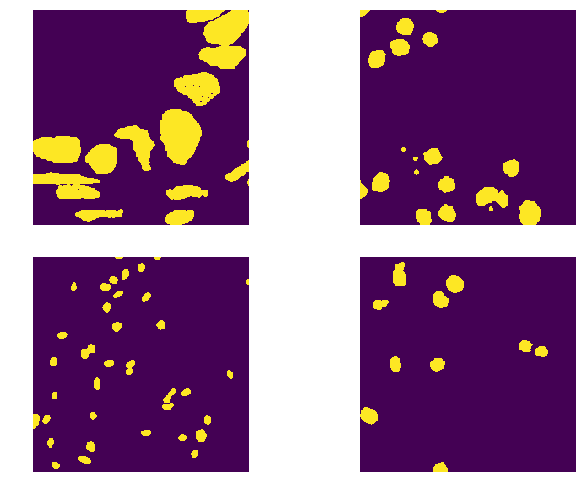

In [23]:
 # Create a segmentation list
source = (SegmentationItemList
            .from_folder(path_img_train, extensions=['.png'])
            .filter_by_func(filter_only_training_images)
            .split_by_rand_pct(valid_pct=0.2)
            .label_from_func(filter_masks_dir, label_cls=MultiMaskList, classes=['nucl'])
            .transform((rand_pad(0, 256), rand_pad(0, 256)), tfm_y=True)
         )

data_bunch = (source
        .databunch(bs=8)
        .normalize(imagenet_stats))

data_bunch.show_batch(2, figsize=(10,7))

# show some items
#itemList.items

In [53]:
def mean_iou(y_pred, y_true, smooth=1e-6):
    scores = np.zeros(y_true.shape[0])
    y_true = y_true.squeeze(1)
    y_pred = torch.sigmoid(y_pred).squeeze(1)
    for i in range(y_true.shape[0]):
        labels_pred = label(y_pred.to('cpu').numpy()[i] > 0.5)
        labels_true = label(y_true.to('cpu').numpy()[i])
        score = 0
        cnt = 0
        n_masks_pred = np.max(labels_pred)
        n_masks_true = np.max(labels_true)
        inter_union = np.zeros((n_masks_pred, n_masks_true, 2), dtype=np.int)
        for k in range(y_true.shape[1]):
            for l in range(y_true.shape[2]):
                m = labels_pred[k, l]
                n = labels_true[k, l]
                if m != 0:
                    inter_union[m-1, :, 1] += 1
                if n != 0:
                    inter_union[:, n-1, 1] += 1
                if m != 0 and n != 0:
                    inter_union[m-1, n-1, 0] += 1
        ious = inter_union[:, :, 0]/(
            inter_union[:, :, 1]-inter_union[:, :, 0]+smooth)
        for t in np.arange(0.5, 1.0, 0.05):
            cnt += 1
            tp = 0
            fp = 0
            fn = 0
            fn_tests = np.ones(n_masks_true, dtype=np.bool)
            for m in range(n_masks_pred):
                fp_test = True
                for n in range(n_masks_true):
                    if ious[m, n] > t:
                        tp += 1
                        fp_test = False
                        fn_tests[n] = False
                if fp_test:
                    fp += 1
            fn = np.count_nonzero(fn_tests)
            try:
                score += tp/(tp+fp+fn)
            except ZeroDivisionError:
                pass
        score = score/cnt
        scores[i] = score
    return torch.tensor(scores).mean()

In [24]:
learner = unet_learner(data_bunch, models.resnet34, metrics=error_rate, wd=1e-2, callback_fns=ShowGraph).to_fp16()

In [25]:
learner.lr_find()
learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

In [ ]:
learner.fit_one_cycle(10, 1e-3)